In [135]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.datasets import load_iris

In [141]:
# Read Dataset
# Load the iris dataset
iris = load_iris()
raw_df = pd.DataFrame(iris.data, columns=iris.feature_names)
X, y = iris.data, iris.target

In [102]:
# Feature scaling with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [150]:
raw_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [149]:
raw_df.isna().sum()

sepal length (cm)    10
sepal width (cm)     10
petal length (cm)    10
petal width (cm)     10
dtype: int64

In [136]:
data_.describe()

,sepal length (cm),sepal width (cm),petal width (cm),target
count,1.500000e+02,1.500000e+02,1.500000e+02,150.000000
mean,-1.468455e-15,-1.823726e-15,-9.473903e-16,1.000000
std,1.003350e+00,1.003350e+00,1.003350e+00,0.819232
min,-1.870024e+00,-2.433947e+00,-1.447076e+00,0.000000
25%,-9.006812e-01,-5.923730e-01,-1.183812e+00,0.000000
50%,-5.250608e-02,-1.319795e-01,1.325097e-01,1.000000
75%,6.745011e-01,5.586108e-01,7.906707e-01,2.000000
max,2.492019e+00,3.090775e+00,1.712096e+00,2.000000


<Axes: >

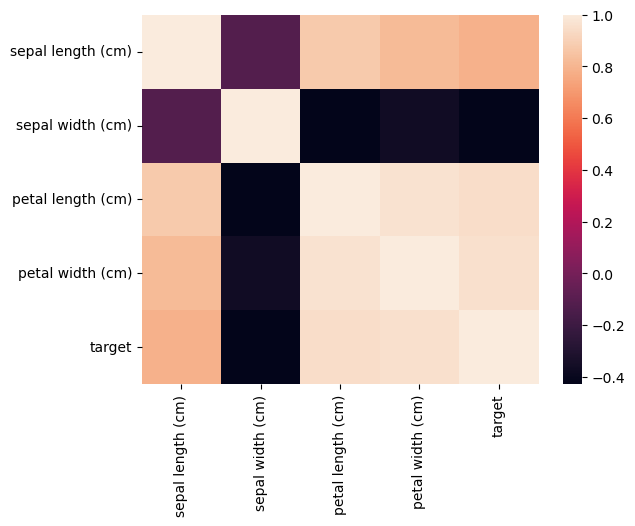

In [103]:
# print(X.corr())
data_ = pd.DataFrame(X_scaled, columns=iris.feature_names)
data_['target'] = y
data_

sns.heatmap(data_.corr())

In [153]:
vif_data = pd.DataFrame()
vif_data['Features'] = data_.columns
vif_data['VIF'] = [variance_inflation_factor(data_.values,i) for i in range(len(data_.columns))]
vif_data

,Features,VIF
0,sepal length (cm),3.417679
1,sepal width (cm),1.311843
2,petal width (cm),4.374958
3,target,1.584916


In [105]:
data_= data_[vif_data[vif_data.VIF <= 20].Features.values]
data_ 

,sepal length (cm),sepal width (cm),petal width (cm),target
0,-0.900681,1.019004,-1.315444,0
1,-1.143017,-0.131979,-1.315444,0
2,-1.385353,0.328414,-1.315444,0
3,-1.506521,0.098217,-1.315444,0
4,-1.021849,1.249201,-1.315444,0
...,...,...,...,...
145,1.038005,-0.131979,1.448832,2
146,0.553333,-1.282963,0.922303,2
147,0.795669,-0.131979,1.053935,2
148,0.432165,0.788808,1.448832,2


In [106]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_.drop(columns='target'), data_.target, test_size=0.2, random_state=123, stratify=y)

In [131]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.003, 0.01, 0.1, 0.2],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    # 'class_weight': ['balanced'],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# Set up StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False, eval_metric='mlogloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.003, 'max_depth': 3, 'n_estimators': 100}


In [126]:
# Best model
best_model = grid_search.best_estimator_
print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.003, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)


In [127]:
# Make predictions
y_pred = best_model.predict(X_test)

In [128]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}") 

Accuracy: 0.97


In [129]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score: {f1:.2f}') 

F1 score: 0.97


In [113]:
X_test

,sepal length (cm),sepal width (cm),petal width (cm)
80,-0.416010,-1.513160,-0.130755
45,-1.264185,-0.131979,-1.183812
144,1.038005,0.558611,1.712096
110,0.795669,0.328414,1.053935
38,-1.748856,-0.131979,-1.315444
2,-1.385353,0.328414,-1.315444
135,2.249683,-0.131979,1.448832
72,0.553333,-1.282963,0.395774
138,0.189830,-0.131979,0.790671
34,-1.143017,0.098217,-1.315444


Machine Learning Model Implementation Steps:
1. Missing Values Handling:
    - Use MICE technique for data imputation
    - Use SimpleImputer from sklearn: mean, median, most_frequent, constant
2. Correlated Feature Handling:
    - Variance Inflation Factor
    - If high correlation then drop the features Iteratively
3. One-Hot Encoder: pd.getdummies
4. Feature Scaling:
    - Check for Normal Distribution using Shapiro-Wilk Test
    - MinMax scaler, Standard Scaler, RobustScaler for Normalization
    - RobutScaler if Outlier and data not normal, Standard Scaler if normal
5. StratefiedKfold: Cross-validation
6. GridSearchCV:
    - Best Combination of Parameters
7. Model Evaluation:
    - accuracy
    - f1 score

In [ ]:
Classification:
XGBoost (or Randomforest)
SVM
KNearestClassifier

Regression:
- OLS Regression (Maximum Likelihood Estimator: MLE)
- Ridge
- XGBRegressor (RFRegressor)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
iris = load_iris()
X, y = iris.data, iris.target

# Introduce some missing values for demonstration
np.random.seed(0)
missing_mask = np.random.rand(*X.shape) < 0.1
X[missing_mask] = np.nan

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the pipeline
pipeline = Pipeline([
    ('imputer', IterativeImputer(random_state=42)),  # Data imputation step
    ('feature_selection', SelectKBest(f_classif)),  # Feature selection step
    ('scaler', StandardScaler()),  # Feature scaling step
    ('mlp', MLPClassifier(random_state=42))  # MLPClassifier step
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [2, 3, 4],  # Number of features to select
    'mlp__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],  # Different architectures
    'mlp__activation': ['tanh', 'relu'],  # Activation functions
    'mlp__solver': ['sgd', 'adam'],  # Solvers
    'mlp__alpha': [0.0001, 0.05],  # Regularization parameter
    'mlp__learning_rate': ['constant', 'adaptive'],  # Learning rate schedules
    'mlp__max_iter': [200, 400, 600]  # Number of epochs
}

# Set up StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [154]:
from scipy.stats import shapiro
from sklearn.datasets import load_iris
import pandas as pd

# Load the Iris dataset
iris = load_iris()
X = iris.data
feature_names = iris.feature_names

# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=feature_names)

# Perform Shapiro-Wilk test for each feature
shapiro_results = {}
for feature in df.columns:
    stat, p_value = shapiro(df[feature])
    shapiro_results[feature] = {'Statistic': stat, 'p-value': p_value, 'Normal (p>0.05)': p_value > 0.05}

# Print the results
for feature, result in shapiro_results.items():
    print(f"{feature}: Statistic={result['Statistic']:.4f}, p-value={result['p-value']:.4f}, Normal (p>0.05)={result['Normal (p>0.05)']}")


sepal length (cm): Statistic=0.9761, p-value=0.0102, Normal (p>0.05)=False
sepal width (cm): Statistic=0.9849, p-value=0.1011, Normal (p>0.05)=True
petal length (cm): Statistic=0.8763, p-value=0.0000, Normal (p>0.05)=False
petal width (cm): Statistic=0.9018, p-value=0.0000, Normal (p>0.05)=False


In [ ]:
I have a class defined in python, which has two functions: one for building XGBClassifier and another with MLPClassifier

MLPClassfier functions contains the below:
# Define the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': [2, 3, 4],  # Number of features to select
    'mlp__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],  # Different architectures
    'mlp__activation': ['tanh', 'relu'],  # Activation functions
    'mlp__solver': ['sgd', 'adam'],  # Solvers
    'mlp__alpha': [0.0001, 0.05],  # Regularization parameter
    'mlp__learning_rate': ['constant', 'adaptive'],  # Learning rate schedules
    'mlp__max_iter': [200, 400, 600]  # Number of epochs
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

XGBClassfier contains this:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.003, 0.01, 0.1, 0.2],
    # 'subsample': [0.7, 0.8, 0.9],
    # 'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    # 'class_weight': ['balanced'],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False, eval_metric='mlogloss')

In [156]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset (using Iris dataset as an example)
iris = load_iris()
X, y = iris.data, iris.target

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False]         # Whether bootstrap samples are used when building trees
}

# Set up Stratified K-Fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kfold, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Best model
best_rf_model = grid_search.best_estimator_

# Perform cross-validation with best model (optional)
cv_results = cross_val_score(best_rf_model, X, y, cv=kfold, scoring='accuracy')
print(f"Cross-validation accuracy: {np.mean(cv_results):.2f} +/- {np.std(cv_results):.2f}")

# Alternatively, split data into train and test sets and evaluate the best model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit and predict with best model
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
644 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/aakashrathod/opt/anaconda3/envs/pyenv/lib/python3.8/site-packages/sklearn/ba

Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Cross-validation accuracy: 0.97 +/- 0.03
Accuracy on test set: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
